In [10]:
%run ../setup_notebook.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pandas as pd
import pickle
from termcolor import cprint
from subsets_analysis import Subsets

from utils import cacher
from gsheets_importer import gsheet2df

In [12]:
pkl_path = '/home/jrowland/mnt/qnap/run_pkls'
figure_path = os.path.expanduser('~/all_psychometics')

if not os.path.exists(figure_path):
    os.mkdir(figure_path)

In [13]:
def load_run(mouse, run_number, pkl_path):
    run_path = os.path.join(pkl_path, mouse, f'run{run_number}.pkl')
    with open(run_path, 'rb') as f:
        run = pickle.load(f)
    return run

In [14]:
def get_subset_dprime(run):
    
    trial_subsets = Subsets(run).trial_subsets
    assert trial_subsets.shape == run.outcome.shape
    
    fp_rate = sum(run.outcome=='fp') / (sum(run.outcome=='fp') + sum(run.outcome=='cr'))
    subset_dprimes = []
    
    good = True
    
    for subset in [[5],[10],[20],[30],[40],[50],[150]]:
        idx = np.isin(trial_subsets, subset)
        outcome = run.outcome[idx]
        hit_rate = sum(outcome=='hit') / (sum(outcome=='hit') + sum(outcome=='miss'))
        dp = utils.d_prime(hit_rate, fp_rate)
        subset_dprimes.append(dp) 
        
        if 40 in subset or 50 in subset:
            if dp < 0.5:
                good = False
        elif 150 in subset:
            if dp < 1:
                good = False
        
    return subset_dprimes, good

In [15]:
def plot_psycho(subset_dprimes):
    
    plt.plot([5,10,20,30,40,50,150], subset_dprimes, '.')
    plt.xlabel("number cells stimmed")
    plt.ylabel('dprime')
    plt.ylim(min(subset_dprimes)-0.1, max(subset_dprimes)+0.1)

    plt.axhline(0.5, linestyle=':')
    plt.axhline(1, linestyle=':')
    

In [21]:
def save_figure(name, base_path='/home/jrowland/mnt/qnap/Figures/bois'):
    plt.rcParams['pdf.fonttype'] = 42
    plt.savefig(os.path.join(base_path, f'{name}.pdf'),
                bbox_inches='tight', transparent=True)

In [16]:
df = gsheet2df('1SMhz8dC6vmPTcOaFQsh50H4pxeKdBxh63UyR1u2K8I8', 4, 'Sheet1!A:G')
mice = df.Mouse.unique()
mice = mice[~np.isin(mice, ['', 'Mouse'])]

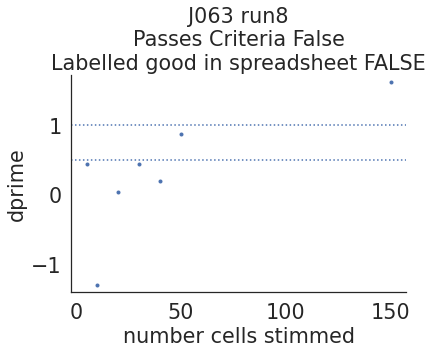

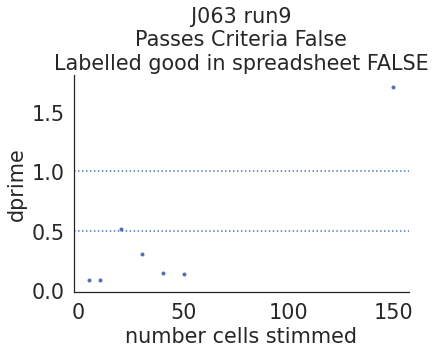

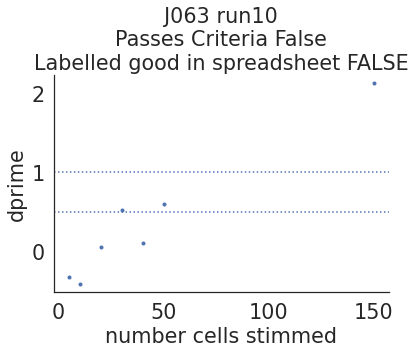

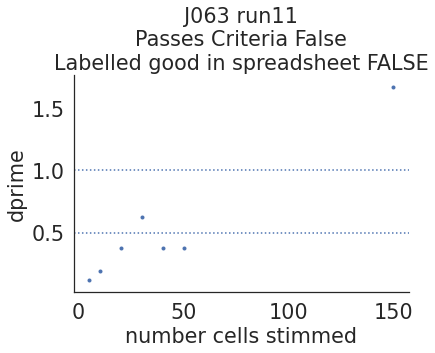

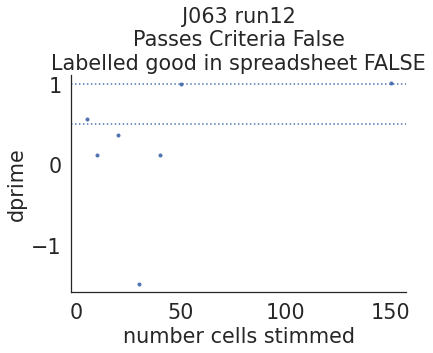

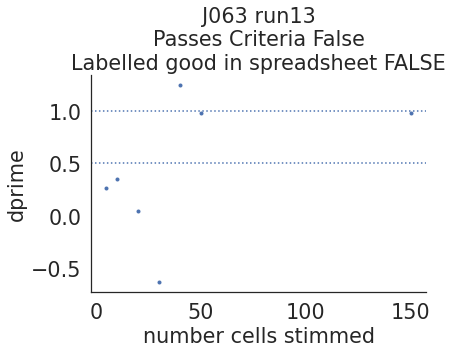

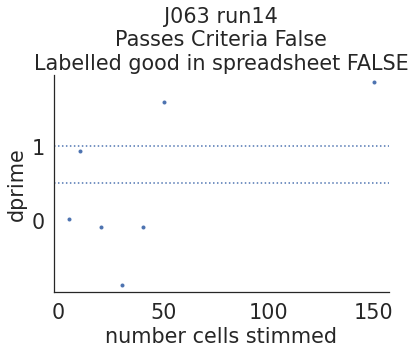

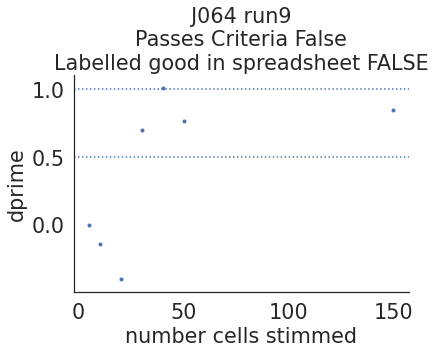

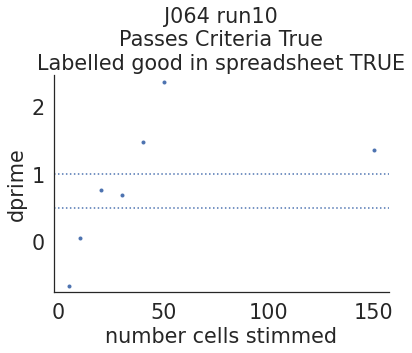

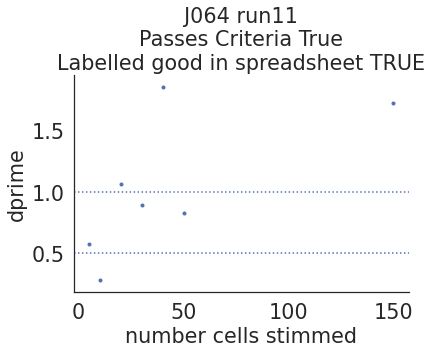

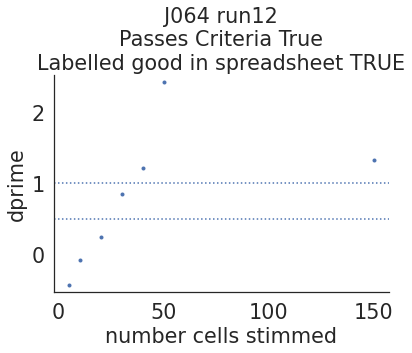

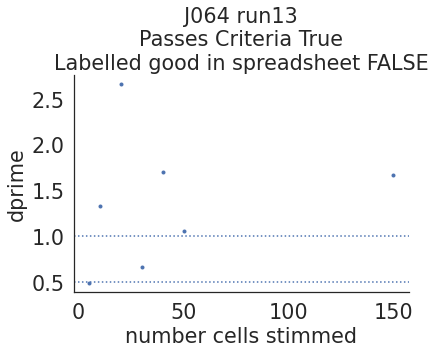

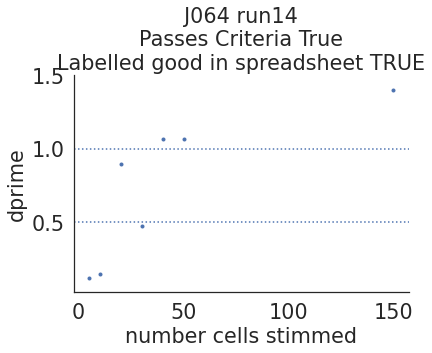

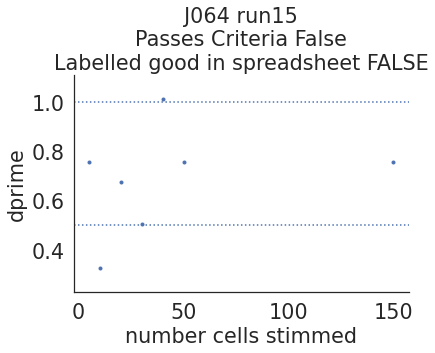

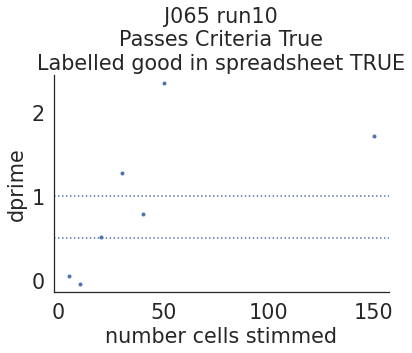

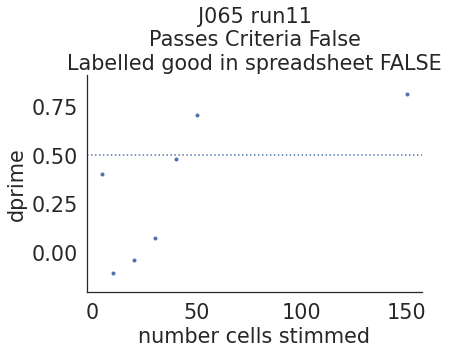

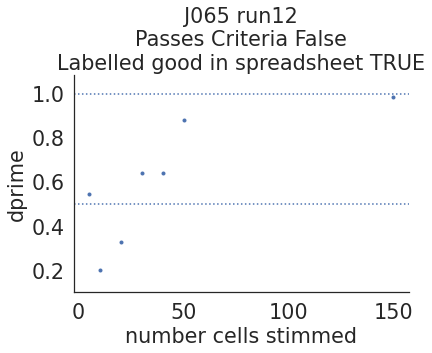

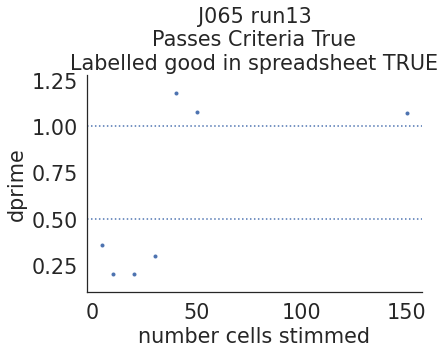

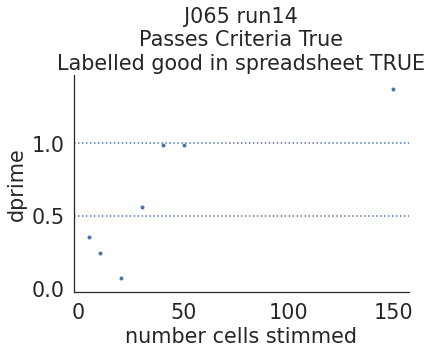

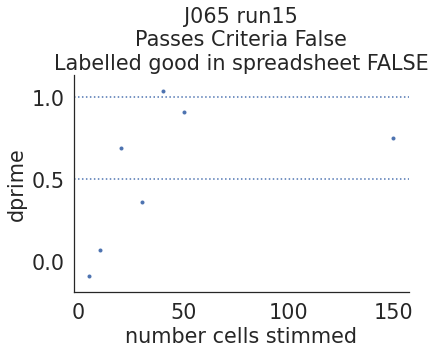

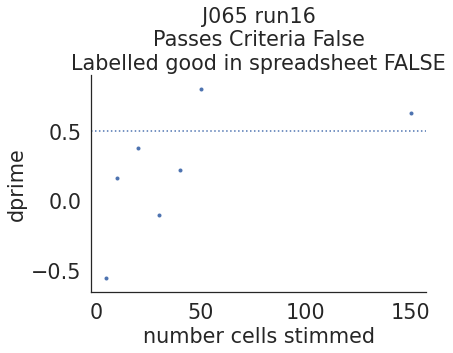

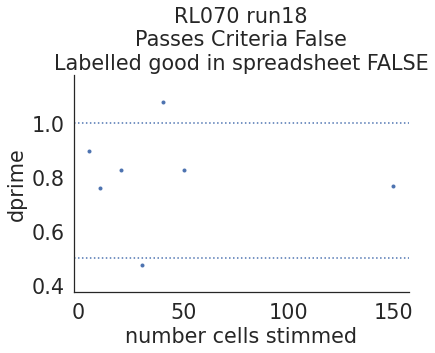

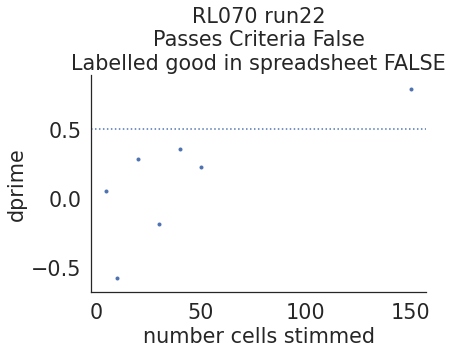

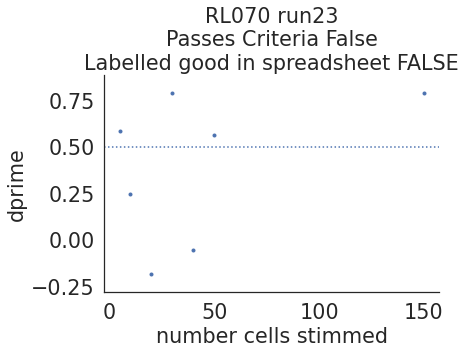

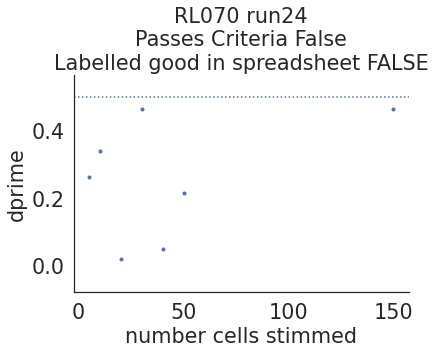

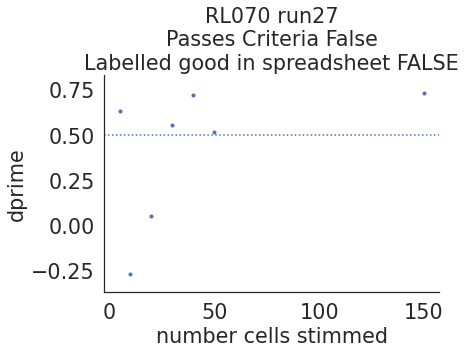

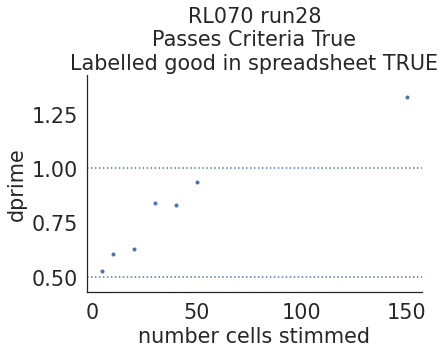

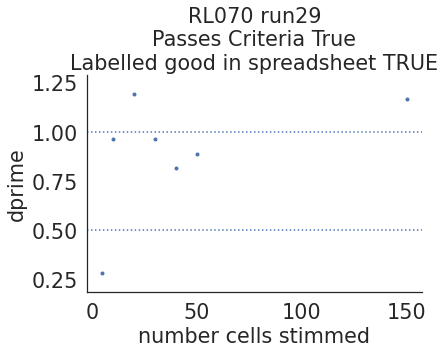

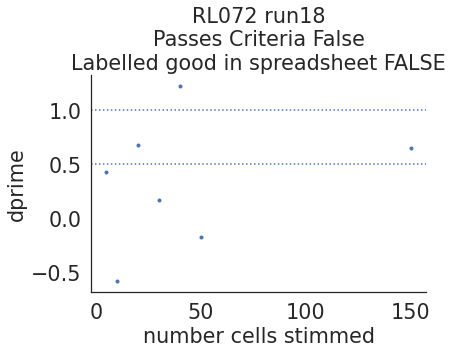

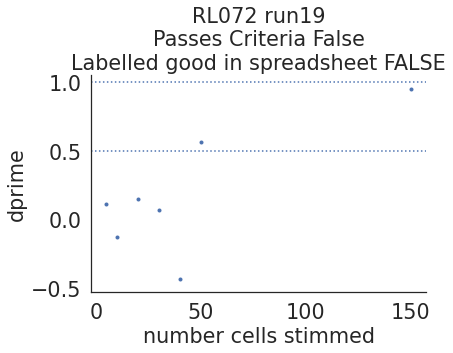

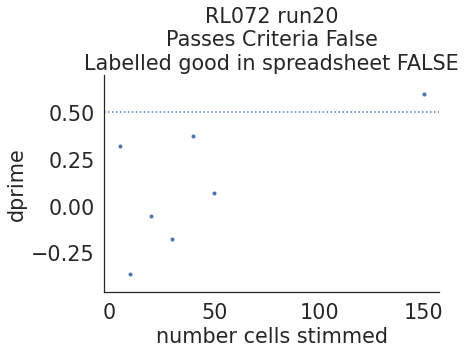

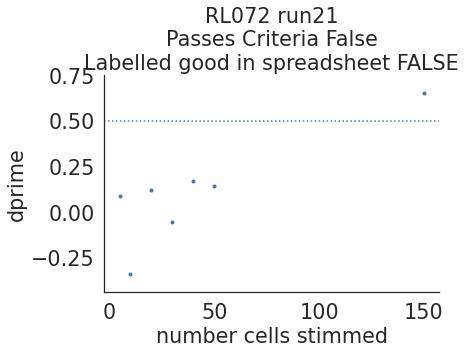

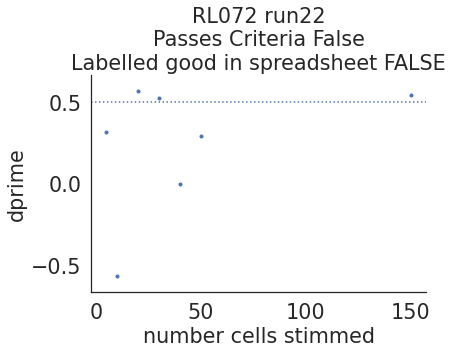

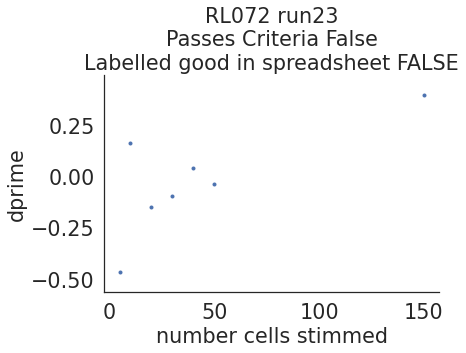

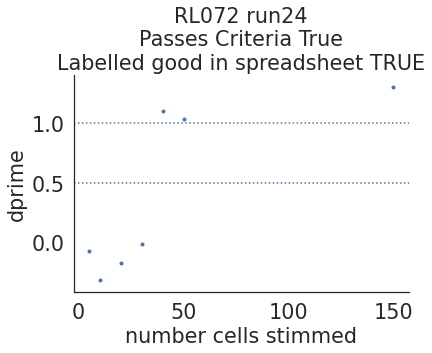

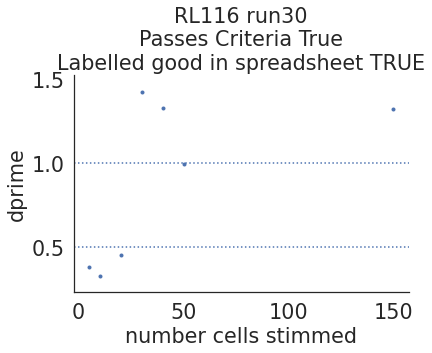

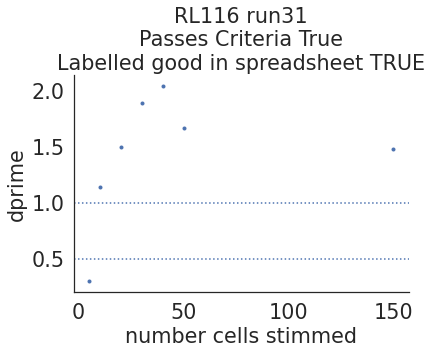

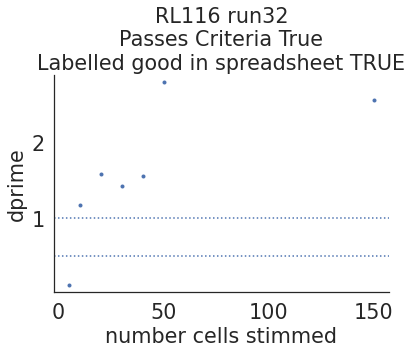

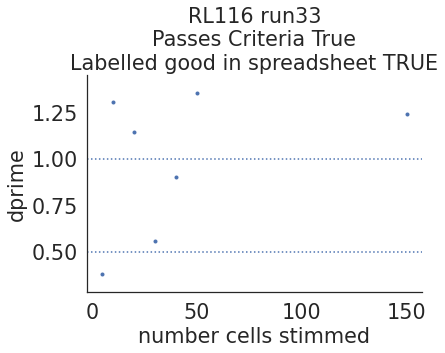

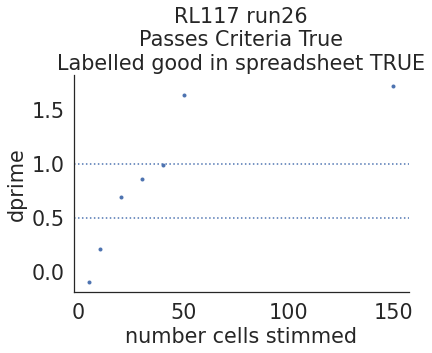

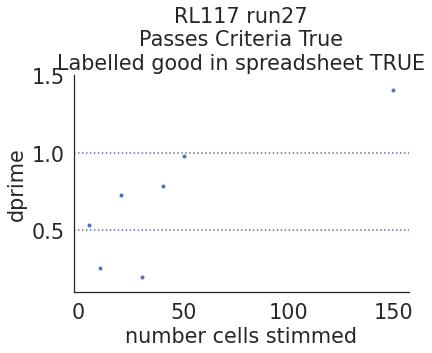

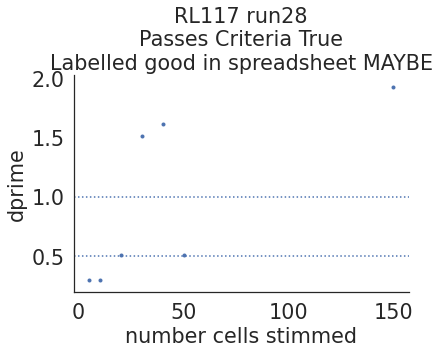

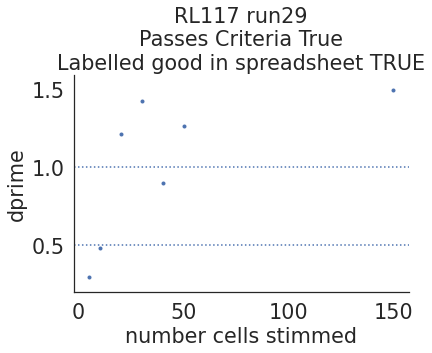

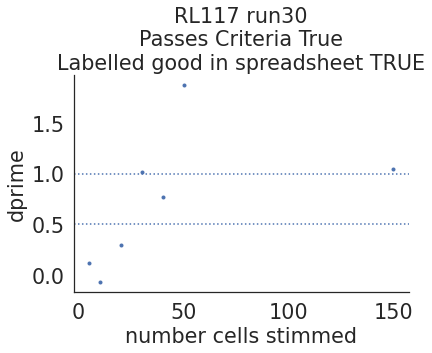

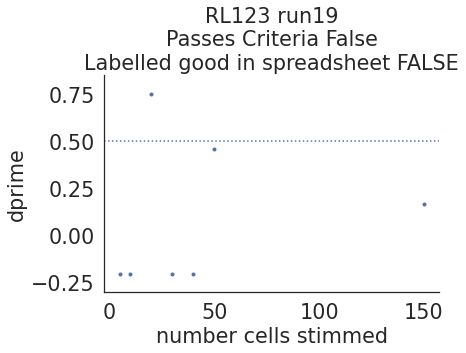

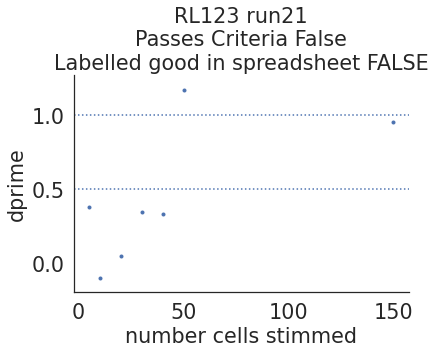

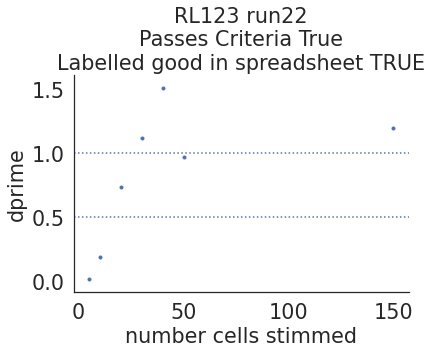

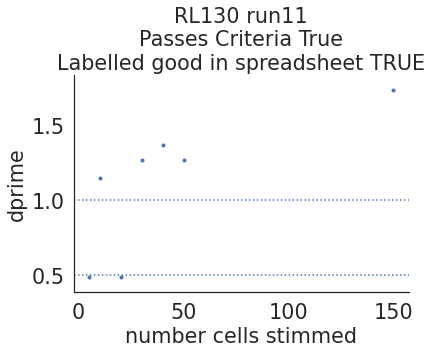

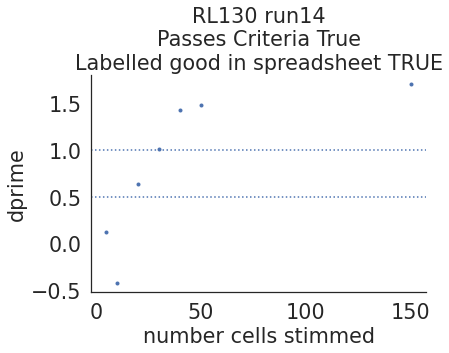

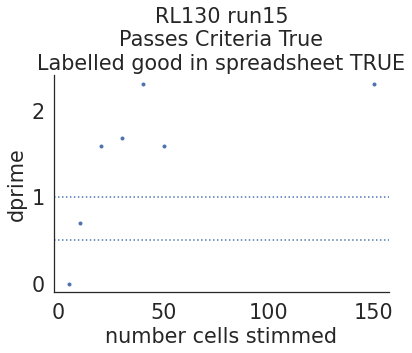

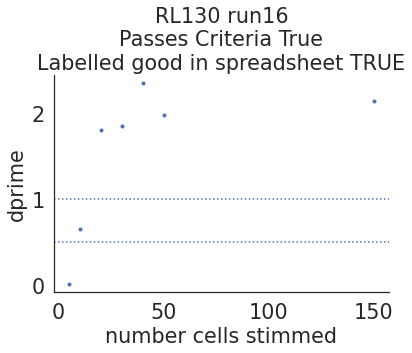

In [22]:
for mouse in mice:
    
    idx = df.index[df['Mouse'] == mouse]
    df_mouse = df.loc[idx]

    for run_number, labelled_good in zip(df_mouse['Run number'], df_mouse['Behaviour good?']):

        run_number = int(run_number)

        try:
            run = load_run(mouse, run_number, pkl_path)
        except FileNotFoundError:
            continue

        subset_dprimes, good = get_subset_dprime(run)

        plt.figure()
        plot_psycho(subset_dprimes)

        nl = '\n'
        title_str = f'{run.mouse_id} run{run_number}{nl}Passes Criteria {good}{nl}'\
                    f'Labelled good in spreadsheet {labelled_good}'

        plt.title(title_str)

        save_figure(f'{mouse}_run{run_number}.png', figure_path)

In [ ]:
for row in df:
    print(row)